In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import os


In [2]:
housing_data = pd.read_csv(f"{os.getcwd()}{os.sep}housing.csv")
housing_data.head(5)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing_data.info()
# ocean_proximity is a string data
# There are some lissing data for total number of bedrooms

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing_data["ocean_proximity"].value_counts()
# There are only 5 categories. So it's categorical column

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


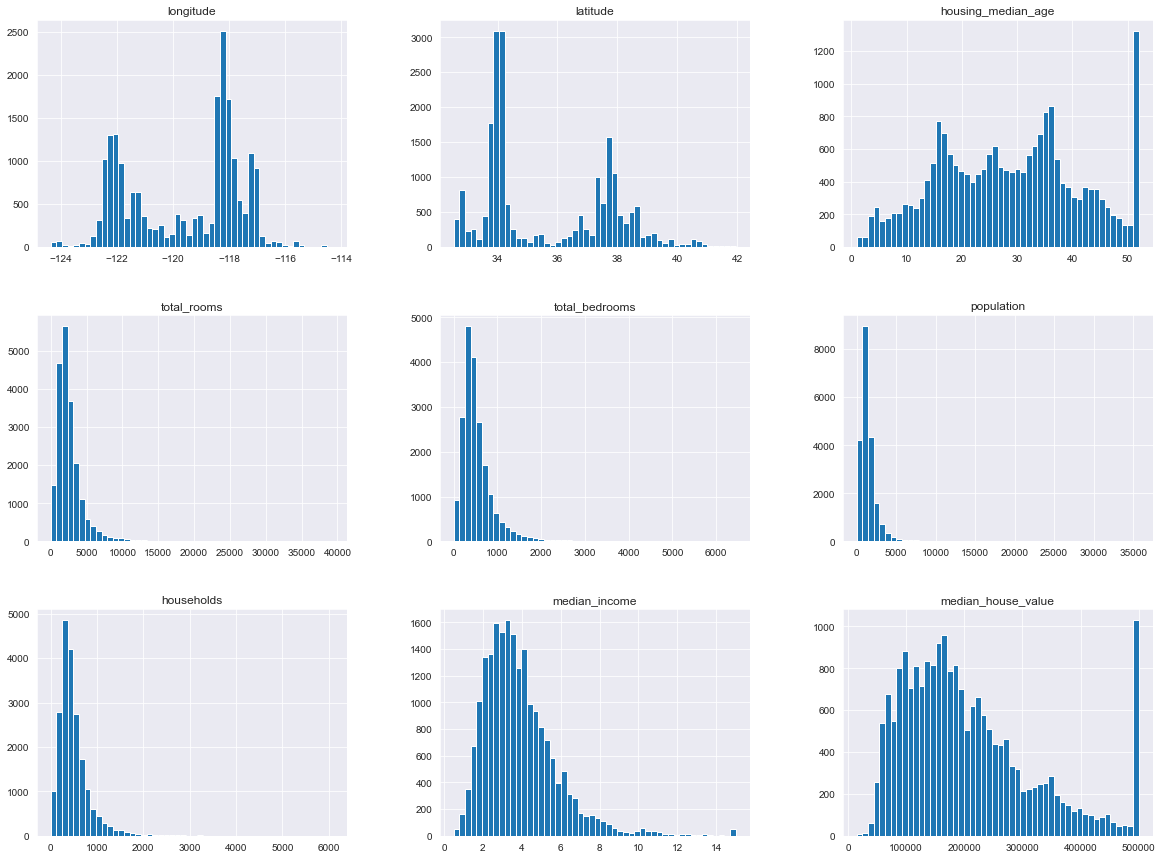

In [6]:
sns.set_style('darkgrid')
housing_data.hist(bins=50, figsize=(20,15));
# Looks like Medion income is not in USD, it's capped at 15.
# Many plots are tail heavy, we will transform these attributes such that we have bell shaped plots. Which will be easier for ML models to train on.


## Creating a test set.
### Random Test set
    The issue with random test set is, that it will pick the values randomly. It won't represent the entire dataset, and will result in bias.
### Stratified Test set
    Using stratified split, we get the values which represents the entire dataset. And it makes more sense to use this to get better output.

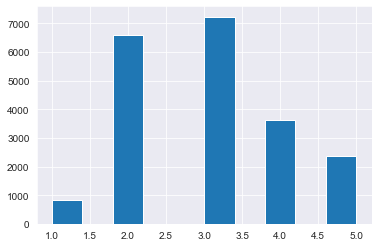

In [7]:
# stratified test split
# We need a column that is catergorical to create stratified test split.
# Assuming, median income is a major feature to predict median house price, we are using that
# Since median income is a continuous data, we need to convert it to categorial data.

housing_data["median_income_category"] = pd.cut(
    housing_data["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)
housing_data["median_income_category"].hist();


In [8]:
# random test split
from sklearn.model_selection import train_test_split

random_train_test, random_test_set = train_test_split(
    housing_data, test_size=0.2, random_state=42
)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in strat_split.split(housing_data, housing_data["median_income_category"]):
    strat_train_set = housing_data.loc[train_idx]
    strat_test_set  = housing_data.loc[test_idx]

In [10]:
def income_cat_proportions(data):
    return data["median_income_category"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing_data),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(random_test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [11]:
# We no longer need median_income_category column, so we can drop it
for _ in (strat_test_set, strat_train_set):
    _.drop("median_income_category", axis=1, inplace=True)

In [12]:
train_set_copy = strat_train_set.copy()

## Looking for Correlations!

In [13]:
corr_matrix = train_set_copy.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [14]:
corr_matrix['median_house_value'].sort_values(ascending=False)
# Median income has the highest correlation with median house values

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

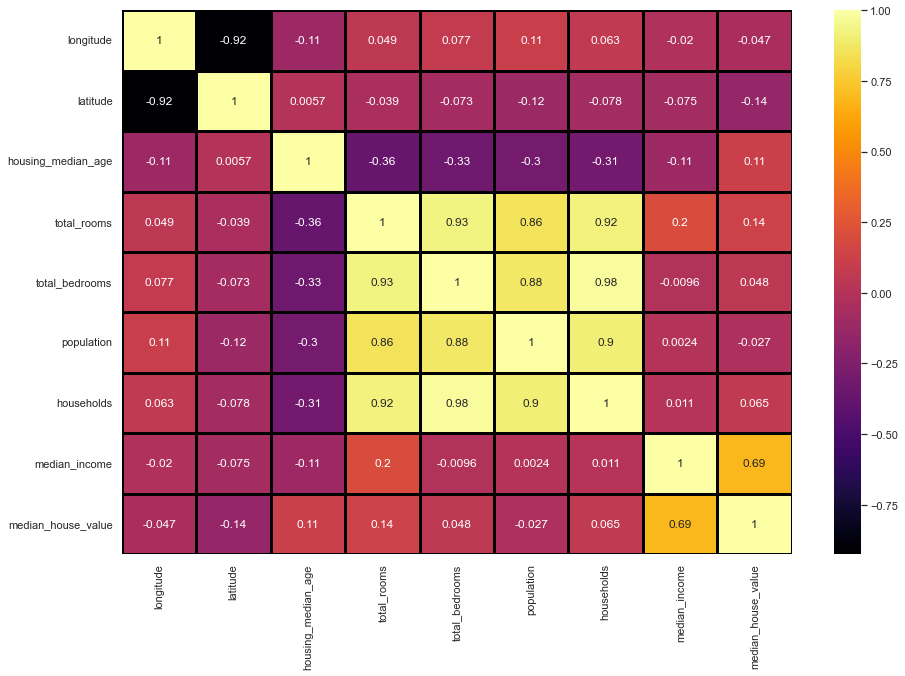

In [15]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(corr_matrix, cmap='inferno', annot=True, linewidths=2.5, linecolor='black');


In [16]:
# Experiment with combining attributes!
train_set_copy['rooms_per_household']   = train_set_copy['total_rooms'] / train_set_copy['households']
train_set_copy['bedrooms_per_room']     = train_set_copy['total_bedrooms'] / train_set_copy['total_rooms']
train_set_copy['population_per_household']   = train_set_copy['population'] / train_set_copy['households']

In [17]:
corr_matrix_updated = train_set_copy.corr()
corr_matrix_updated['median_house_value'].sort_values(ascending=False)
# The newly derived column rooms_per_household has better correlation compared to total_rooms or bedrooms

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

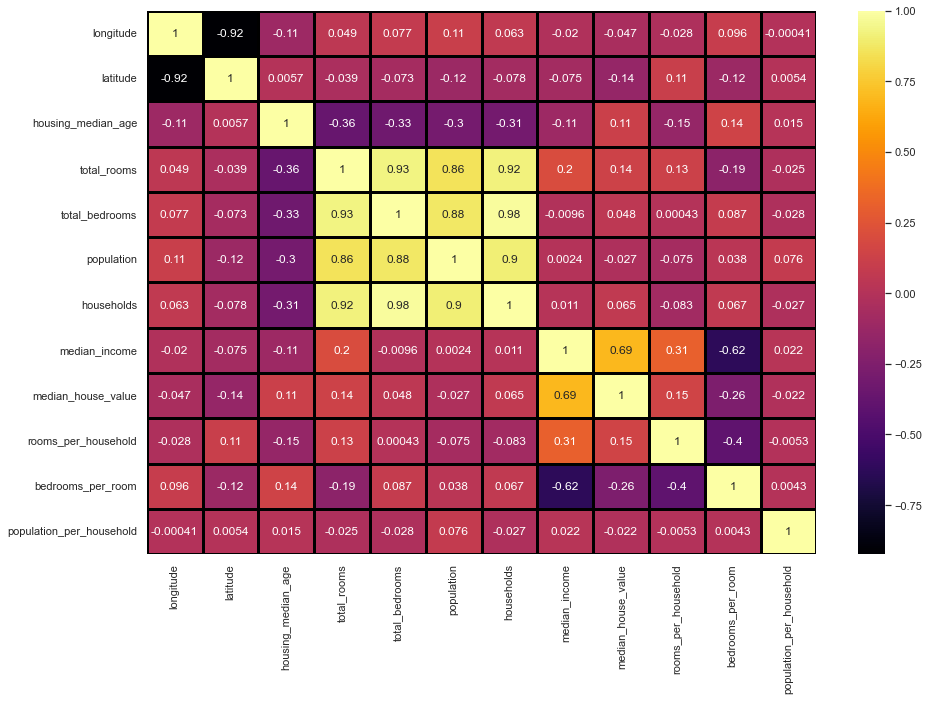

In [18]:
# sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(corr_matrix_updated, cmap='inferno', annot=True, linewidths=2.5, linecolor='black');

## Cleaning the data

In [19]:
# Handling Missing value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
train_set_copy_num = train_set_copy.drop('ocean_proximity', axis=1)

In [20]:
imputer.fit(train_set_copy_num)

SimpleImputer(strategy='median')

In [21]:
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        1.79500000e+05,  5.23234164e+00,  2.03027043e-01,  2.81766108e+00])

In [22]:
train_set_copy_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        1.79500000e+05,  5.23234164e+00,  2.03027043e-01,  2.81766108e+00])

In [24]:
X = imputer.transform(train_set_copy_num)
housing_tr = pd.DataFrame(
    X, columns=train_set_copy_num.columns, index=train_set_copy_num.index
)
housing_tr.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   rooms_per_household       16512 non-null  float64
 10  bedrooms_per_room         16512 non-null  float64
 11  population_per_household  16512 non-null  float64
dtypes: float64(12)
memory usage: 1.6 MB


In [25]:
# Handling Categorical data
train_set_copy_str = train_set_copy[['ocean_proximity']]
train_set_copy_str.head(5)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


In [30]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train_set_copy_str_enc = ordinal_encoder.fit_transform(train_set_copy_str)
train_set_copy_str_enc[:10]
# This encoding will give numbers for each catergory, since we have 5 diff categories, the number will range from 0-4
np.unique(train_set_copy_str_enc)
# This will make the model think that there is some meaning to those numbers, like 1 is greater than 0, etc. Which is not the case, so.

array([0., 1., 2., 3., 4.])

In [32]:
# OneHotEnocding
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
housing_cat_one_hot = onehot_encoder.fit_transform(train_set_copy_str)
housing_cat_one_hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])